In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import colormaps  



In [13]:
# example session
#  LOAD INTERMEDIATE DATA

# # # User input: session folder
session_folder = "/root/capsule/scratch/session_analysis_in_distribution/behavior_716325_2024-05-31_10-31-14"

# Build paths
intermediate_dir = Path(session_folder) / "intermediate_data"
movements_path = intermediate_dir / "tongue_movs.parquet"
kins_path = intermediate_dir / "tongue_kins.parquet"
df_trials_path = intermediate_dir / "nwb_df_trials.parquet"
df_licks_path = intermediate_dir / "nwb_df_licks.parquet"

# Load dataframes
tongue_movements = pd.read_parquet(movements_path)
df_trials = pd.read_parquet(df_trials_path)
df_licks = pd.read_parquet(df_licks_path)
tongue_kinematics = pd.read_parquet(kins_path)

print(tongue_movements.columns)

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event'],
      dtype='object')


In [15]:
# example analysis

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import aggregate_tongue_movements, add_lick_metadata_to_movements, annotate_movement_timing

# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


In [32]:
FIG_DIR = Path("/root/capsule/scratch/figures/latency")
SAVE_FIG = True


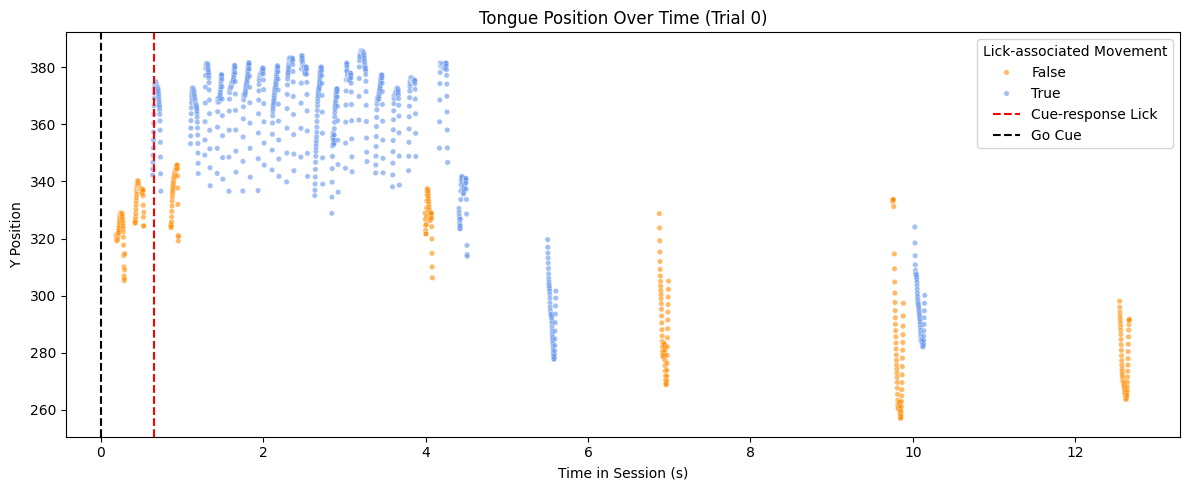

In [28]:
# # Trials with ≥1 non-lick movement that ended before cue-response lick
# trials_with_prelick_nonlick = (
#     movements[
#         (movements["has_lick"] == False) &
#         (movements["pre_cue_response"] == True)
#     ]["trial"]
#     .unique()
# )


# trial_to_plot = trials_with_prelick_nonlick[25]  # pick the first one



# # Filter tongue_segmented for this trial
# df_trial = tongue_segmented[tongue_segmented["trial"] == trial_to_plot].copy()
trial_to_plot = 0
trial_kins = tongue_kinematics[tongue_kinematics["trial"] == trial_to_plot].copy()

# Map has_lick from movements onto tongue_segmented
trial_kins = trial_kins.merge(
    tongue_movements[["movement_id", "has_lick"]],
    on="movement_id",
    how="left"
)

# Fill missing movement_id (NaN frames) with False
trial_kins["has_lick"] = trial_kins["has_lick"].astype(bool).fillna(False)

# Plot
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=trial_kins,
    x="time_in_session",
    y="y",
    hue="has_lick",
    palette={True: "cornflowerblue", False: "darkorange"},
    alpha=0.6,
    s=15
)

# Annotate first lick
first_lick_time = tongue_movements[
    (tongue_movements["trial"] == trial_to_plot) &
    (tongue_movements["cue_response"])
]["lick_time"].values[0]
plt.axvline(first_lick_time, color="red", linestyle="--", label="Cue-response Lick")

# Add goCue line
gocue_time = tongue_movements[
    (tongue_movements["trial"] == trial_to_plot)]["goCue_start_time_in_session"].values[0]
plt.axvline(gocue_time, color="black", linestyle="dashed", label="Go Cue")

# Formatting
plt.title(f"Tongue Position Over Time (Trial {trial_to_plot})")
plt.xlabel("Time in Session (s)")
plt.ylabel("Y Position")
plt.legend(title="Lick-associated Movement")
plt.tight_layout()
plt.show()



/tmp/ipykernel_3426/699937279.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.map({True: True, False: False, 1: True, 0: False, 'True': True, 'False': False}).fillna(False)


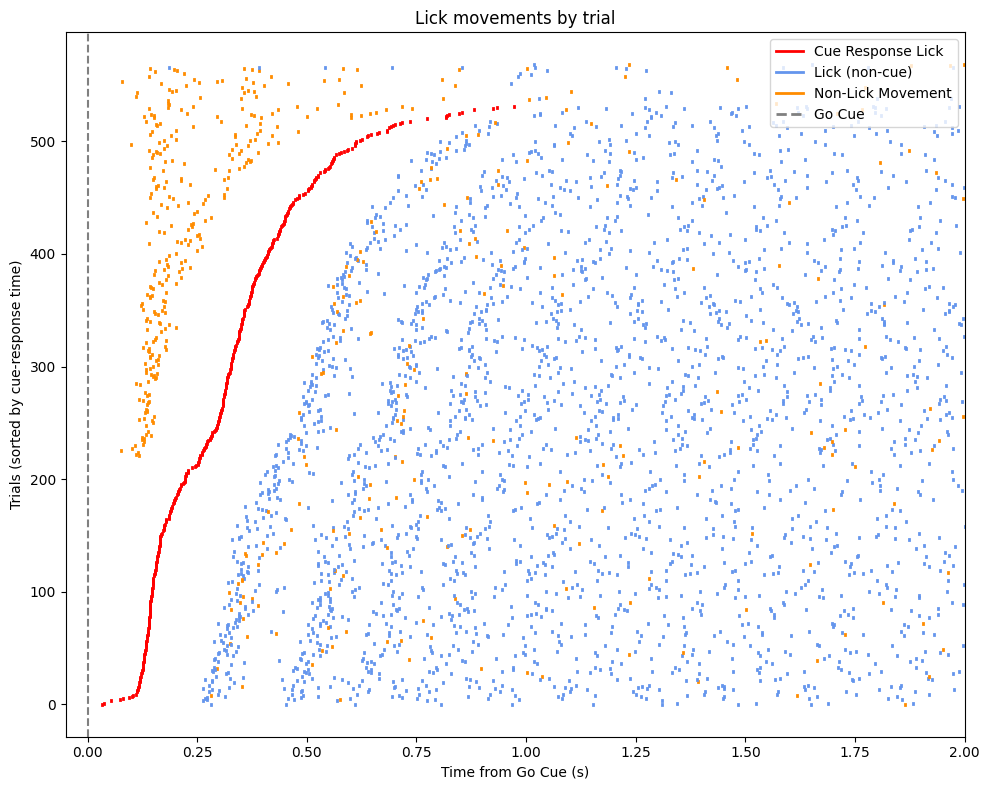

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ================== CONFIG ==================
XMIN, XMAX = -.05, 2           # x-axis window
FALLBACK_SORT = False        # if a trial has no cue-response, sort by its earliest movement
LINE_HALFHEIGHT = 0.4       # half height of each raster tick
# ============================================

df = tongue_movements.copy()

# --- Robust boolean coercion (treat None/NaN as False) ---
# Avoid astype(bool) on strings, which can turn any non-empty string into True.
def coerce_bool(s):
    return s.map({True: True, False: False, 1: True, 0: False, 'True': True, 'False': False}).fillna(False)

df['cue_response'] = coerce_bool(df['cue_response'])
df['has_lick']     = coerce_bool(df['has_lick'])

# Ensure numeric for times/indices
df['movement_number_in_trial'] = pd.to_numeric(df['movement_number_in_trial'], errors='coerce')
df['movement_latency_from_go'] = pd.to_numeric(df['movement_latency_from_go'], errors='coerce')

# --- 1) Cue-response time per trial (relative to go cue) ---
cue_rows = df.loc[df['cue_response']].copy()
cue_response_by_trial = (
    cue_rows.sort_values(['trial','movement_number_in_trial'])
            .drop_duplicates('trial', keep='first')
            [['trial','movement_latency_from_go']]
            .rename(columns={'movement_latency_from_go': 'cue_rel_time'})
)

# --- Optional fallback: earliest movement time for trials with no cue-response ---
if FALLBACK_SORT:
    first_move_by_trial = (
        df.sort_values(['trial','movement_number_in_trial'])
          .dropna(subset=['movement_latency_from_go'])
          .groupby('trial', as_index=False)['movement_latency_from_go'].first()
          .rename(columns={'movement_latency_from_go': 'fallback_time'})
    )
else:
    first_move_by_trial = pd.DataFrame(columns=['trial','fallback_time'])

# --- 2) Merge into raster dataframe ---
raster = (
    df.merge(cue_response_by_trial, on='trial', how='left')
      .merge(first_move_by_trial, on='trial', how='left')
)

# Sort key: cue_rel_time first; if NaN and FALLBACK_SORT, use fallback_time; NaNs last
if FALLBACK_SORT:
    sort_key = raster['cue_rel_time'].copy()
    # where cue_rel_time is NaN, use fallback_time
    sort_key = sort_key.where(sort_key.notna(), raster['fallback_time'])
else:
    sort_key = raster['cue_rel_time']

sorted_trials = (
    raster.assign(_sort_key=sort_key)
          [['trial','_sort_key']]
          .drop_duplicates()
          .sort_values('_sort_key', na_position='last')
          ['trial'].tolist()
)

# --- 3) Map trials to row indices ---
trial_to_idx = {t: i for i, t in enumerate(sorted_trials)}
raster['trial_idx'] = raster['trial'].map(trial_to_idx)

# --- 4) Colors: cue_response -> red; else has_lick -> cornflowerblue; else darkorange ---
raster['color'] = np.select(
    [raster['cue_response'], raster['has_lick']],
    ['red', 'cornflowerblue'],
    default='darkorange'
)

# --- 5) Plot ---
plt.figure(figsize=(10, 8))

valid = raster['movement_latency_from_go'].notna() & raster['trial_idx'].notna()
for row in raster.loc[valid].itertuples(index=False):
    x = row.movement_latency_from_go
    y = row.trial_idx
    plt.plot([x, x], [y - LINE_HALFHEIGHT, y + LINE_HALFHEIGHT], color=row.color, linewidth=2)

# Go cue reference
plt.axvline(0, color='gray', linestyle='--')

# Window + labels
plt.xlim(XMIN, XMAX)
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Cue Response Lick'),
    Line2D([0], [0], color='cornflowerblue', lw=2, label='Lick (non-cue)'),
    Line2D([0], [0], color='darkorange', lw=2, label='Non-Lick Movement'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Go Cue'),
]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel("Time from Go Cue (s)")
plt.ylabel("Trials (sorted by cue-response time)")
plt.title("Lick movements by trial")
plt.tight_layout()
plt.show()


/tmp/ipykernel_3426/3353861806.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.map({True: True, False: False, 1: True, 0: False, 'True': True, 'False': False}).fillna(False)


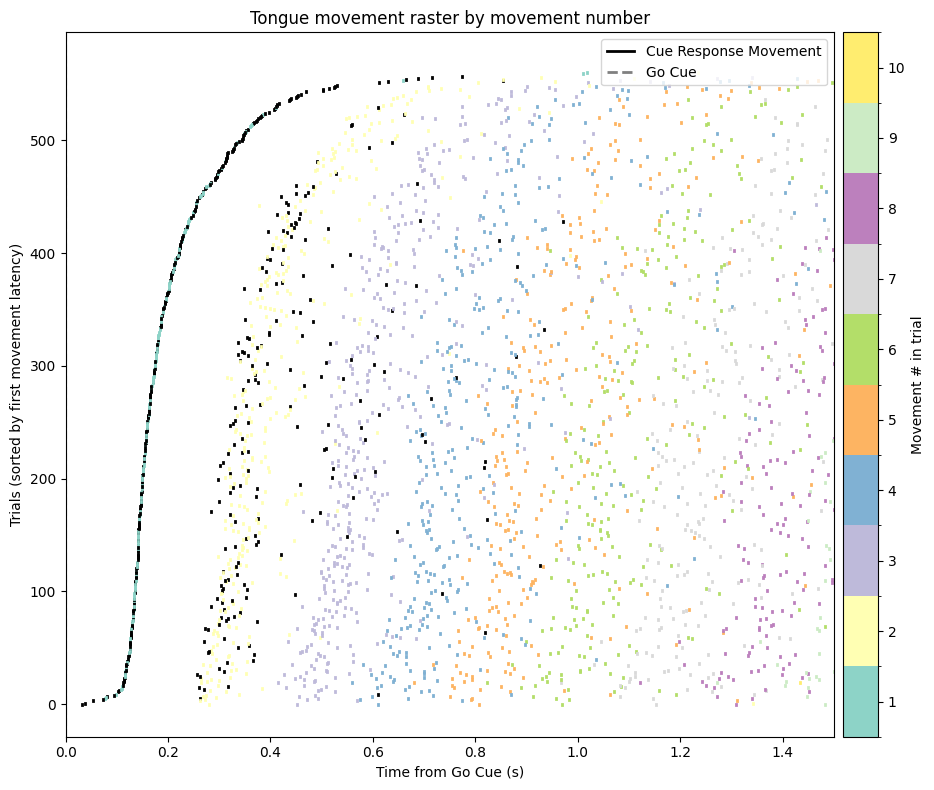

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import BoundaryNorm

# ================== CONFIG ==================
XMIN, XMAX = 0, 1.5
LINE_HALFHEIGHT = 0.4
CMAP_BASE = 'Set3'     # no reds
# ============================================

df = tongue_movements.copy()

def coerce_bool(s):
    return s.map({True: True, False: False, 1: True, 0: False, 'True': True, 'False': False}).fillna(False)

df['cue_response'] = coerce_bool(df['cue_response'])
df['has_lick']     = coerce_bool(df['has_lick'])
df['movement_number_in_trial'] = pd.to_numeric(df['movement_number_in_trial'], errors='coerce')
df['movement_latency_from_go'] = pd.to_numeric(df['movement_latency_from_go'], errors='coerce')

# 1) Sort trials by first movement latency
first_move_by_trial = (
    df.dropna(subset=['movement_latency_from_go'])
      .sort_values(['trial','movement_number_in_trial'])
      .groupby('trial', as_index=False)['movement_latency_from_go'].first()
      .rename(columns={'movement_latency_from_go': 'first_move_time'})
)
raster = df.merge(first_move_by_trial, on='trial', how='left')

sorted_trials = (
    raster[['trial','first_move_time']]
      .drop_duplicates()
      .sort_values('first_move_time', na_position='last')
      ['trial'].tolist()
)
trial_to_idx = {t: i for i, t in enumerate(sorted_trials)}
raster['trial_idx'] = raster['trial'].map(trial_to_idx)

# 2) Discrete colormap range from movements actually drawn in the window
valid = raster['movement_latency_from_go'].notna() & raster['trial_idx'].notna()
in_window = valid & raster['movement_latency_from_go'].between(XMIN, XMAX, inclusive='both')

k_in_window = raster.loc[in_window, 'movement_number_in_trial'].dropna()
if not k_in_window.empty:
    vmin, vmax = int(np.nanmin(k_in_window)), int(np.nanmax(k_in_window))
else:
    all_k = raster['movement_number_in_trial'].dropna()
    vmin, vmax = (int(np.nanmin(all_k)), int(np.nanmax(all_k))) if not all_k.empty else (1, 4)

# Build discrete colormap with one color per integer k
levels = np.arange(vmin, vmax + 1)                    # integers that appear on ticks
boundaries = np.arange(vmin - 0.5, vmax + 1.5, 1)     # bin edges to center colors on integers
cmap = plt.get_cmap(CMAP_BASE, len(levels))           # discretized colormap
norm = BoundaryNorm(boundaries, cmap.N)

def color_for_row(row):
    if row['cue_response']:
        return 'black'  # override for cue-response
    k = row['movement_number_in_trial']
    if pd.isna(k):
        return cmap(norm(vmin))
    # round/clip to nearest valid integer bin
    kk = int(np.clip(round(k), vmin, vmax))
    return cmap(norm(kk))

raster['color'] = raster.apply(color_for_row, axis=1)

# 3) Plot
fig, ax = plt.subplots(figsize=(10, 8))

for row in raster.loc[valid].itertuples(index=False):
    x = row.movement_latency_from_go
    y = row.trial_idx
    ax.plot([x, x], [y - LINE_HALFHEIGHT, y + LINE_HALFHEIGHT], color=row.color, linewidth=2)

ax.axvline(0, color='gray', linestyle='--')
ax.set_xlim(XMIN, XMAX)

# Discrete colorbar with integer ticks
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])  # not strictly required
cbar = fig.colorbar(mappable, ax=ax, pad=0.01, boundaries=boundaries, ticks=levels, spacing='proportional')
cbar.set_label('Movement # in trial')

# Legend + labels
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='Cue Response Movement'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Go Cue'),
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel("Time from Go Cue (s)")
ax.set_ylabel("Trials (sorted by first movement latency)")
ax.set_title("Tongue movement raster by movement number")
fig.tight_layout()
plt.show()


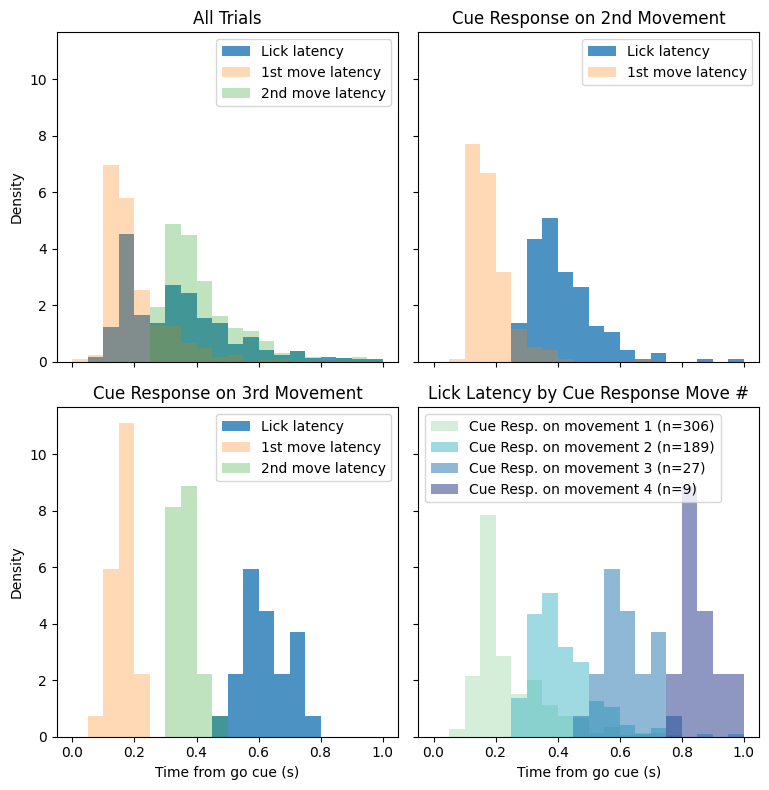

In [7]:
# plotting results: latency of cue response tongue movements, sorted by movement ordinal

# --- Shared settings ---
bins = np.arange(0, 1.05, 0.05)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.ravel()

# -------------------------------
# Subplot 1: All trials
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="All Trials", ylabel="Density")
ax.legend()

# -------------------------------
# Subplot 2: Cue response on 2nd movement
# -------------------------------
trials_2nd = df.loc[df['cue_response_movement_number'] == 2, 'trial'].unique()
df_2nd = df.query("trial in @trials_2nd and movement_number_in_trial <= 2")

lick_lat = df_2nd.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df_2nd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']

ax = axes[1]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.set(title="Cue Response on 2nd Movement")
ax.legend()

# -------------------------------
# Subplot 3: Cue response on 3rd movement
# -------------------------------
trials_3rd = df.loc[df['cue_response_movement_number'] == 3, 'trial'].unique()
df_3rd = df.query("trial in @trials_3rd and movement_number_in_trial <= 3")

lick_lat = df_3rd.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df_3rd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[2]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="Cue Response on 3rd Movement", xlabel="Time from go cue (s)", ylabel="Density")
ax.legend()

# -------------------------------
# Subplot 4: Lick latency by cue_response_movement_number (1-4)
# -------------------------------
per_trial = (
    tongue_movements
      .dropna(subset=['lick_latency', 'cue_response_movement_number'])
      .drop_duplicates('trial')                # <- critical: keep a single row per trial
      .copy()
)
lick_latencies_by_cue = (
    per_trial
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

cmap = plt.colormaps['YlGnBu']
colors = cmap(np.linspace(0.3, 0.9, 4))

ax = axes[3]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True, alpha=0.5,
        label=f"Cue Resp. on movement {n} (n={len(latencies)})",
        color=colors[n-1]
    )
ax.set(title="Lick Latency by Cue Response Move #", xlabel="Time from go cue (s)")
ax.legend(loc="upper left")

# --- Final layout ---
fig.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "latency_cue-response_by_movement-ordinal"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")






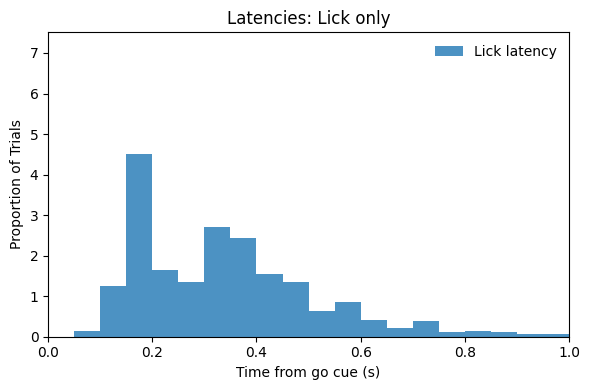

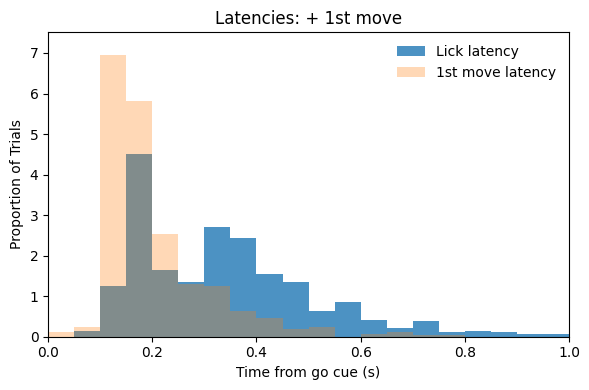

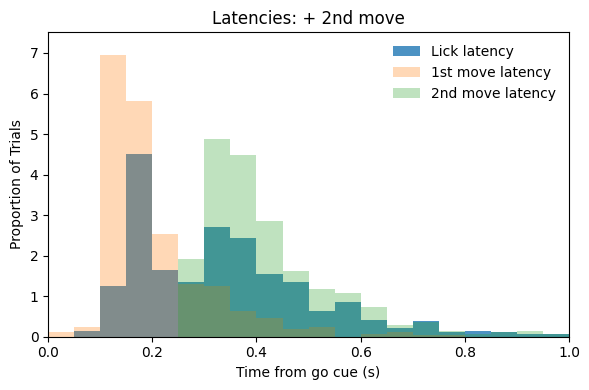

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# --- Settings (match your palette) ---
bins = np.arange(0, 1.05, 0.05)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3
figsize = (6, 4)   # adjust as needed
xlabel = "Time from go cue (s)"
ylabel = "Proportion of Trials"
title_prefix = "Latencies"

# --- Extract latencies ---
df = tongue_movements.copy()

# Lick latency (one per trial)
lick_lat = (
    df.drop_duplicates('trial')['lick_latency']
      .dropna()
)

# Movement latencies ordered within each trial
moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = (
    moves.groupby('trial')
         .nth(0)['movement_latency_from_go']
         .dropna()
)
second_move = (
    moves.groupby('trial')
         .nth(1)['movement_latency_from_go']
         .dropna()
)

# --- Compute shared axis limits ---
# Use density=True like the plots; take the max bin height across all three
def max_density(arr):
    if len(arr) == 0:
        return 0.0
    hist, _ = np.histogram(arr, bins=bins, density=True)
    return hist.max() if len(hist) else 0.0

ymax = max(
    max_density(lick_lat),
    max_density(first_move),
    max_density(second_move),
)
# Add a small headroom so the tallest bar doesn't touch the top
ymax = ymax * 1.08 if ymax > 0 else 1.0

xlim = (bins[0], bins[-1])
ylim = (0, ymax)

# --- Panel A: Lick latency only ---
figA, axA = plt.subplots(figsize=figsize)
axA.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
axA.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: Lick only")
axA.legend(frameon=False)
figA.tight_layout()
if SAVE_FIG:
    fname = FIG_DIR / "latency_vs_lick_lickonly"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    figA.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    figA.savefig(f"{fname}.svg", bbox_inches="tight")

# --- Panel B: + 1st move latency (superimposed) ---
figB, axB = plt.subplots(figsize=figsize)
axB.hist(lick_lat,   bins=bins, density=True, alpha=alpha_lick, color=colors["lick"],  label="Lick latency")
axB.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
axB.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: + 1st move")
axB.legend(frameon=False)
figB.tight_layout()
if SAVE_FIG:
    fname = FIG_DIR / "latency_vs_lick_firstmove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    figB.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    figB.savefig(f"{fname}.svg", bbox_inches="tight")

# --- Panel C: + 2nd move latency (superimposed) ---
figC, axC = plt.subplots(figsize=figsize)
axC.hist(lick_lat,    bins=bins, density=True, alpha=alpha_lick, color=colors["lick"],   label="Lick latency")
axC.hist(first_move,  bins=bins, density=True, alpha=alpha_move, color=colors["first"],  label="1st move latency")
axC.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
axC.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: + 2nd move")
axC.legend(frameon=False)
figC.tight_layout()
if SAVE_FIG:
    fname = FIG_DIR / "latency_vs_lick_firstandsecondmove"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    figC.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    figC.savefig(f"{fname}.svg", bbox_inches="tight")

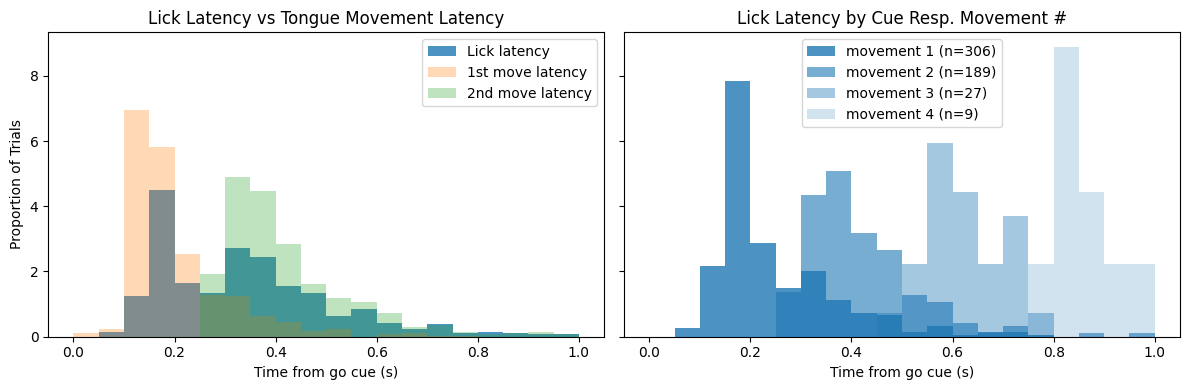

In [33]:
# --- Shared settings ---
bins = np.arange(0, 1.05, 0.05)
base_colors = {
    "lick": "#1f77b4",   # blue
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

# Make side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# -------------------------------
# Panel 1: All trials (like old subplot 1)
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=base_colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=base_colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=base_colors["second"], label="2nd move latency")
ax.set(title="Lick Latency vs Tongue Movement Latency", ylabel="Proportion of Trials", xlabel="Time from go cue (s)")
ax.legend()

# -------------------------------
# Panel 2: Lick latency by cue_response_movement_number (use one color, vary alpha)
# -------------------------------
# One lick per trial, then group
per_trial = (
    tongue_movements
      .dropna(subset=['lick_latency', 'cue_response_movement_number'])
      .drop_duplicates('trial')                # <- critical: keep a single row per trial
      .copy()
)
lick_latencies_by_cue = (
    per_trial
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

# decreasing alpha with movement number
alphas = {1: 0.8, 2: 0.6, 3: 0.4, 4: 0.2}

ax = axes[1]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True,
        alpha=alphas.get(n, 0.2),
        label=f"movement {n} (n={len(latencies)})",
        color=base_colors["lick"]
    )
ax.set(title="Lick Latency by Cue Resp. Movement #", xlabel="Time from go cue (s)")
ax.legend(loc="upper center")

# --- Final layout ---
fig.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "latency_vs_lick"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")


Estimated Δt (median IMI): 0.2020 s


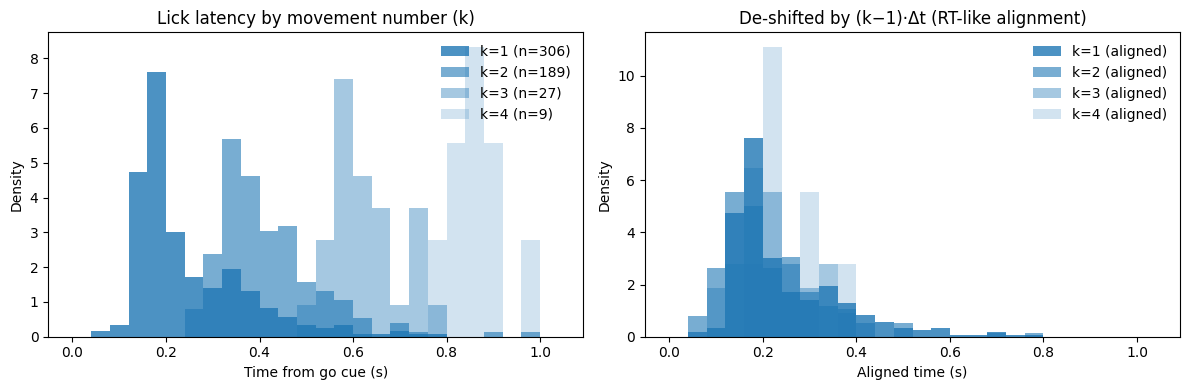


Aligned-shape similarity to k=1 (KS test):
  k=2: KS=0.195, p=0.000217  (n_k=189, n_1=306)
  k=3: KS=0.169, p=0.432  (n_k=27, n_1=306)
  k=4: KS=0.490, p=0.019  (n_k=9, n_1=306)

Aligned medians by k: {1: 0.19790400005877018, 2: 0.18710399977862835, 3: 0.2181440000422299, 4: 0.23731200024485588}
Aligned means by k: {1: 0.2484630588244257, 2: 0.21417583075780716, 3: 0.22328059271805817, 4: 0.26215466691388023}


In [34]:
# === Simple, pandas-style analysis of "RT + IMI" using lick latency conditioned on movement number ===
# Requires `tongue_movements` with columns:
# ['trial','movement_number_in_trial','movement_latency_from_go','lick_latency','cue_response_movement_number']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ----------------------------
# 0) Prep: keep movements up to cue-response; one lick per trial
# ----------------------------
df = tongue_movements.copy()

# robust numerics
for c in ['movement_number_in_trial', 'movement_latency_from_go', 'lick_latency', 'cue_response_movement_number']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# keep rows where the cue-response is known and only movements up to that movement
df = df[df['cue_response_movement_number'].notna() &
        (df['movement_number_in_trial'] <= df['cue_response_movement_number'])].copy()

# one lick per trial (avoid duplication from multiple movement rows)
per_trial = (
    df.dropna(subset=['lick_latency','cue_response_movement_number'])
      .drop_duplicates('trial')[['trial','lick_latency','cue_response_movement_number']]
      .rename(columns={'cue_response_movement_number':'k'})
)

# ----------------------------
# 1) Estimate Δt (inter-movement interval) from within-trial gaps
# ----------------------------
# use movement latencies (up to cue-response) and take median diff per trial
mv = (df.dropna(subset=['movement_latency_from_go','movement_number_in_trial'])
        .sort_values(['trial','movement_number_in_trial'])
        [['trial','movement_number_in_trial','movement_latency_from_go']])

imi_diffs = (
    mv.groupby('trial')['movement_latency_from_go']
      .apply(lambda x: np.diff(x.dropna().to_numpy()))
      .tolist()
)
imi_diffs = np.concatenate([d for d in imi_diffs if (isinstance(d, np.ndarray) and d.size > 0)]) \
            if len(imi_diffs) else np.array([])
Delta_t = float(np.median(imi_diffs)) if imi_diffs.size else np.nan

print(f"Estimated Δt (median IMI): {Delta_t:.4f} s")

# ----------------------------
# 2) Distributions of lick latency by movement k
# ----------------------------
bins = np.arange(0, 1.05, 0.04)
lick_blue = "#1f77b4"
alphas = {1: 0.8, 2: 0.6, 3: 0.4, 4: 0.2}

by_k = (
    per_trial
      .query("k <= 4")  # limit to first 4 for readability; remove if you want all ks
      .groupby('k')['lick_latency']
)

# Panel A: pooled lick-latency histograms by movement number (all same color, varying alpha)
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

for k, series in by_k:
    arr = series.dropna().to_numpy()
    if arr.size == 0: 
        continue
    ax[0].hist(arr, bins=bins, density=True, alpha=alphas.get(int(k), 0.2),
               color=lick_blue, label=f"k={int(k)} (n={arr.size})")

ax[0].set(title="Lick latency by movement number (k)",
          xlabel="Time from go cue (s)", ylabel="Density")
ax[0].legend(frameon=False)

# ----------------------------
# 3) Align (de-shift) by (k-1)*Δt and compare shapes (RT + IMI check)
# ----------------------------
aligned = []
labels = []
for k, series in by_k:
    arr = series.dropna().to_numpy()
    if arr.size == 0:
        continue
    shifted = arr - (int(k)-1) * Delta_t   # remove the IMI offset
    aligned.append(shifted)
    labels.append(int(k))

# Panel B: aligned histograms (should overlap if model holds)
if aligned:
    # choose common bins for aligned data
    all_aligned = np.concatenate(aligned)
    lo, hi = np.nanmin(all_aligned), np.nanmax(all_aligned)
    pad = 0.02 * (hi - lo) if np.isfinite(hi - lo) and (hi > lo) else 0.05
    aligned_bins = np.arange(lo - pad, hi + pad + 1e-9, 0.04)

    for k, arr in zip(labels, aligned):
        ax[1].hist(arr, bins=bins, density=True, alpha=alphas.get(int(k), 0.2),
                   color=lick_blue, label=f"k={k} (aligned)")

ax[1].set(title="De-shifted by (k−1)·Δt (RT-like alignment)",
          xlabel="Aligned time (s)", ylabel="Density")
ax[1].legend(frameon=False)

fig.tight_layout()
plt.show()

# ----------------------------
# 4) Simple statistics: do aligned distributions match k=1?
# ----------------------------
# KS tests: aligned k vs aligned k=1
ks_results = {}
if len(aligned) and (1 in labels):
    # map labels -> arrays
    aligned_map = {k: arr for k, arr in zip(labels, aligned)}
    base = aligned_map.get(1, np.array([]))
    for k in sorted(aligned_map.keys()):
        if k == 1:
            continue
        a = aligned_map[k]; b = base
        if a.size >= 2 and b.size >= 2:
            stat, p = ks_2samp(a, b, alternative='two-sided', mode='auto')
            ks_results[k] = {'ks_stat': float(stat), 'p': float(p), 'n_k': int(a.size), 'n_base': int(b.size)}

# Print a compact summary
print("\nAligned-shape similarity to k=1 (KS test):")
if ks_results:
    for k, r in ks_results.items():
        print(f"  k={k}: KS={r['ks_stat']:.3f}, p={r['p']:.3g}  (n_k={r['n_k']}, n_1={r['n_base']})")
else:
    print("  Not enough data to compare or only one k present.")

# ----------------------------
# 5) (Optional) quick visual check of mean/median after alignment
# ----------------------------
if aligned:
    med_by_k = {k: float(np.median(arr)) for k, arr in zip(labels, aligned) if arr.size}
    mean_by_k = {k: float(np.mean(arr)) for k, arr in zip(labels, aligned) if arr.size}
    print("\nAligned medians by k:", med_by_k)
    print("Aligned means by k:", mean_by_k)


if SAVE_FIG:
    fname = FIG_DIR / "licklatency_by_movement_number_RTalign"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

Estimated Δt (median IMI): 0.2020 s


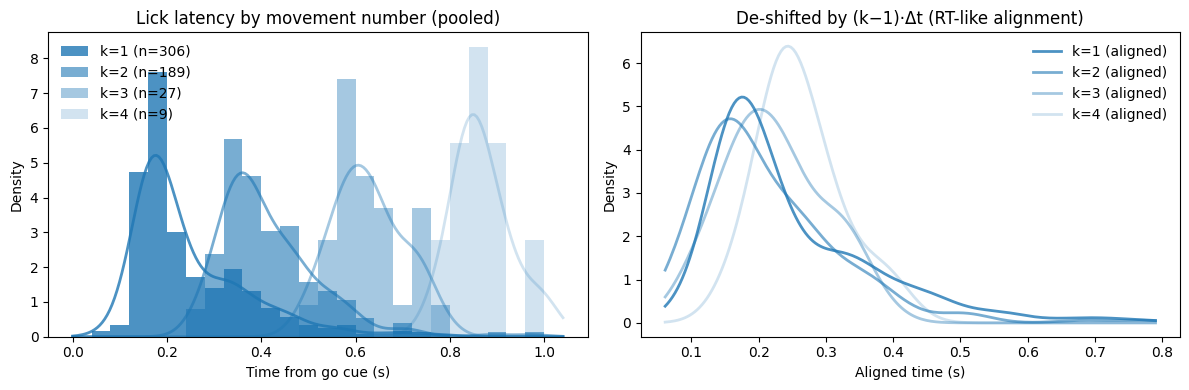


Aligned-shape similarity to k=1 (KS test):
  k=2: KS=0.195, p=0.000217  (n_k=189, n_1=306)
  k=3: KS=0.169, p=0.432  (n_k=27, n_1=306)
  k=4: KS=0.490, p=0.019  (n_k=9, n_1=306)

Aligned medians by k: {1: 0.19790400005877018, 2: 0.18710399977862835, 3: 0.2181440000422299, 4: 0.23731200024485588}
Aligned means by k: {1: 0.2484630588244257, 2: 0.21417583075780716, 3: 0.22328059271805817, 4: 0.26215466691388023}

Propagation of noise (spread vs movement number):


,k,n,mean_latency,std_latency,aligned_mean,aligned_std
0,1,306,0.248463,0.122367,0.248463,0.122367
1,2,189,0.416160,0.106924,0.214176,0.106924
2,3,27,0.627249,0.071678,0.223281,0.071678
3,4,9,0.868107,0.057451,0.262155,0.057451


Linear fit: std ≈ 0.147 + -0.023·k


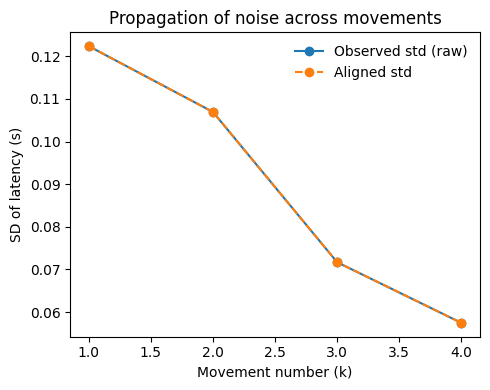

In [28]:
# === Simple, pandas-style analysis of "RT + IMI" using lick latency conditioned on movement number ===
# Requires `tongue_movements` with columns:
# ['trial','movement_number_in_trial','movement_latency_from_go','lick_latency','cue_response_movement_number']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, gaussian_kde

# ----------------------------
# 0) Prep: keep movements up to cue-response; one lick per trial
# ----------------------------
df = tongue_movements.copy()

for c in ['movement_number_in_trial', 'movement_latency_from_go', 'lick_latency', 'cue_response_movement_number']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df[df['cue_response_movement_number'].notna() &
        (df['movement_number_in_trial'] <= df['cue_response_movement_number'])].copy()

per_trial = (
    df.dropna(subset=['lick_latency','cue_response_movement_number'])
      .drop_duplicates('trial')[['trial','lick_latency','cue_response_movement_number']]
      .rename(columns={'cue_response_movement_number':'k'})
)

# ----------------------------
# 1) Estimate Δt (inter-movement interval)
# ----------------------------
mv = (df.dropna(subset=['movement_latency_from_go','movement_number_in_trial'])
        .sort_values(['trial','movement_number_in_trial'])
        [['trial','movement_number_in_trial','movement_latency_from_go']])

imi_diffs = (
    mv.groupby('trial')['movement_latency_from_go']
      .apply(lambda x: np.diff(x.dropna().to_numpy()))
      .tolist()
)
imi_diffs = np.concatenate([d for d in imi_diffs if (isinstance(d, np.ndarray) and d.size > 0)]) \
            if len(imi_diffs) else np.array([])
Delta_t = float(np.median(imi_diffs)) if imi_diffs.size else np.nan
print(f"Estimated Δt (median IMI): {Delta_t:.4f} s")

# ----------------------------
# 2) Distributions of lick latency by movement k
# ----------------------------
bins = np.arange(0, 1.05, 0.04)
lick_blue = "#1f77b4"
alphas = {1: 0.8, 2: 0.6, 3: 0.4, 4: 0.2}

by_k = (
    per_trial
      .query("k <= 4")
      .groupby('k')['lick_latency']
)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

# ----------------------------
# Panel A: histogram + KDE
# ----------------------------
for k, series in by_k:
    arr = series.dropna().to_numpy()
    if arr.size == 0:
        continue
    ax[0].hist(arr, bins=bins, density=True, alpha=alphas.get(int(k), 0.3),
               color=lick_blue, label=f"k={int(k)} (n={arr.size})")
    kde = gaussian_kde(arr)
    xs = np.linspace(bins[0], bins[-1], 200)
    ax[0].plot(xs, kde(xs), color=lick_blue, lw=2, alpha=alphas.get(int(k), 0.5))

ax[0].set(title="Lick latency by movement number (pooled)",
          xlabel="Time from go cue (s)", ylabel="Density")
ax[0].legend(frameon=False)

# ----------------------------
# 3) Align by (k−1)*Δt and compare shapes
# ----------------------------
aligned, labels = [], []
for k, series in by_k:
    arr = series.dropna().to_numpy()
    if arr.size == 0:
        continue
    shifted = arr - (int(k)-1) * Delta_t
    aligned.append(shifted)
    labels.append(int(k))

# ----------------------------
# Panel B: KDE only
# ----------------------------
if aligned:
    all_aligned = np.concatenate(aligned)
    lo, hi = np.nanmin(all_aligned), np.nanmax(all_aligned)
    xs = np.linspace(lo, hi, 200)

    for k, arr in zip(labels, aligned):
        if arr.size == 0:
            continue
        kde = gaussian_kde(arr)
        ax[1].plot(xs, kde(xs), lw=2, alpha=alphas.get(int(k), 0.5),
                   color=lick_blue, label=f"k={k} (aligned)")

ax[1].set(title="De-shifted by (k−1)·Δt (RT-like alignment)",
          xlabel="Aligned time (s)", ylabel="Density")
ax[1].legend(frameon=False)

fig.tight_layout()
plt.show()
if SAVE_FIG:
    fname = FIG_DIR / "licklatency_by_movement_number_RTalign_kde"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")

# ----------------------------
# 4) KS tests vs k=1
# ----------------------------
ks_results = {}
if len(aligned) and (1 in labels):
    aligned_map = {k: arr for k, arr in zip(labels, aligned)}
    base = aligned_map.get(1, np.array([]))
    for k in sorted(aligned_map.keys()):
        if k == 1:
            continue
        a = aligned_map[k]; b = base
        if a.size >= 2 and b.size >= 2:
            stat, p = ks_2samp(a, b)
            ks_results[k] = {'ks_stat': float(stat), 'p': float(p), 'n_k': int(a.size), 'n_base': int(b.size)}

print("\nAligned-shape similarity to k=1 (KS test):")
if ks_results:
    for k, r in ks_results.items():
        print(f"  k={k}: KS={r['ks_stat']:.3f}, p={r['p']:.3g}  (n_k={r['n_k']}, n_1={r['n_base']})")
else:
    print("  Not enough data to compare.")

# ----------------------------
# 5) Quick check of mean/median after alignment
# ----------------------------
if aligned:
    med_by_k = {k: float(np.median(arr)) for k, arr in zip(labels, aligned) if arr.size}
    mean_by_k = {k: float(np.mean(arr)) for k, arr in zip(labels, aligned) if arr.size}
    print("\nAligned medians by k:", med_by_k)
    print("Aligned means by k:", mean_by_k)


# --- Add after section 5 in your current analysis notebook cell ---

# ----------------------------
# 6) Propagation of noise: does variance increase with k?
# ----------------------------
if aligned:
    # collect unaligned and aligned stds
    stats = []
    for k, series in by_k:
        arr = series.dropna().to_numpy()
        if arr.size == 0:
            continue
        aligned_arr = arr - (int(k)-1) * Delta_t
        stats.append({
            'k': int(k),
            'n': len(arr),
            'mean_latency': np.mean(arr),
            'std_latency': np.std(arr),
            'aligned_mean': np.mean(aligned_arr),
            'aligned_std': np.std(aligned_arr)
        })
    stats_df = pd.DataFrame(stats).sort_values('k')
    print("\nPropagation of noise (spread vs movement number):")
    display(stats_df)

    # simple linear regression: does std increase with k?
    if len(stats_df) >= 2:
        slope, intercept = np.polyfit(stats_df['k'], stats_df['std_latency'], 1)
        print(f"Linear fit: std ≈ {intercept:.3f} + {slope:.3f}·k")

    # plot variance growth
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(stats_df['k'], stats_df['std_latency'], 'o-', label='Observed std (raw)')
    ax.plot(stats_df['k'], stats_df['aligned_std'], 'o--', label='Aligned std')
    ax.set(xlabel='Movement number (k)', ylabel='SD of latency (s)',
           title='Propagation of noise across movements')
    ax.legend(frameon=False)
    fig.tight_layout()



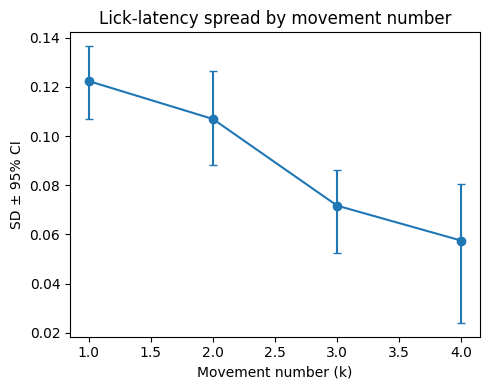

In [29]:
import numpy as np

def bootstrap_std_ci(data, n_boot=1000, alpha=0.05):
    if len(data) < 5:
        return np.nan, np.nan
    boot = [np.std(np.random.choice(data, len(data), replace=True)) for _ in range(n_boot)]
    return np.percentile(boot, [100*alpha/2, 100*(1-alpha/2)])

stats_df['std_ci_low'], stats_df['std_ci_high'] = zip(*[
    bootstrap_std_ci(per_trial.query("k == @k")['lick_latency'].dropna().to_numpy())
    for k in stats_df['k']
])
fig, ax = plt.subplots(figsize=(5,4))
ax.errorbar(stats_df['k'], stats_df['std_latency'],
             yerr=[stats_df['std_latency'] - stats_df['std_ci_low'],
                   stats_df['std_ci_high'] - stats_df['std_latency']],
             fmt='o-', capsize=3)
ax.set(xlabel='Movement number (k)', ylabel='SD ± 95% CI',
       title='Lick-latency spread by movement number')
fig.tight_layout()


I think this is because there are EVEN MORE 'covert' preparatory tongue movements occuring in k=1 and k=2 in particular. you can see secondary 'bump' in the distributions.

In [67]:
movements_path = "/root/capsule/scratch/all_tongue_movements_06102025.parquet"
all_tongue_movements = pd.read_parquet(movements_path)

In [68]:
all_tongue_movements.columns

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event', 'lick_time',
       'goCue_start_time_in_session', 'movement_number_in_trial',
       'cue_response_movement_number', 'movement_before_cue_response',
       'movement_latency_from_go', 'lick_latency', 'session'],
      dtype='object')

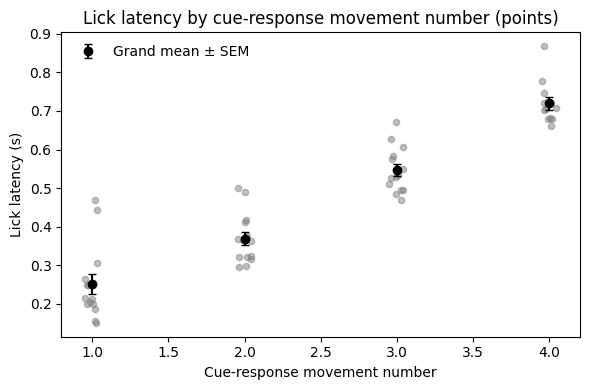

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MAX_K = 4

sessions = all_tongue_movements['session'].unique()
summary = []

for sess in sessions:
    per_trial = (
        all_tongue_movements
          .query("session == @sess")
          .dropna(subset=['lick_latency', 'cue_response_movement_number'])
          .drop_duplicates('trial')          # <- one row per trial
          .copy()
    )

    per_trial = per_trial.query("cue_response_movement_number > 0 and cue_response_movement_number <= @MAX_K")

    group = (
        per_trial
        .groupby('cue_response_movement_number', observed=True)['lick_latency']
        .agg(mean='mean',
             median='median',
             sem=lambda x: x.std(ddof=1)/np.sqrt(len(x)),
             n='size')
        .reset_index()
        .assign(session=sess)
    )
    summary.append(group)

summary_df = pd.concat(summary, ignore_index=True)

grand = (
    summary_df
    .groupby('cue_response_movement_number', observed=True)
    .agg(grand_mean=('mean','mean'),
         grand_sem=('mean', lambda x: x.std(ddof=1)/np.sqrt(x.size)),
         n_sessions=('session','nunique'))
    .reset_index()
)

# --- Plot with points ---
fig = plt.figure(figsize=(6,4))

# gray points = per-session means (slight jitter)
for sess, df_s in summary_df.groupby('session'):
    x = df_s['cue_response_movement_number'].values
    y = df_s['mean'].values
    x_jitter = x + np.random.uniform(-0.05, 0.05, size=len(x))
    plt.scatter(x_jitter, y, color='gray', alpha=0.5, s=20, zorder=1)

# thick black points = grand mean ± SEM
plt.errorbar(
    grand['cue_response_movement_number'],
    grand['grand_mean'],
    yerr=grand['grand_sem'],
    fmt='o', color='k', markersize=6, elinewidth=1.5, capsize=3, zorder=3,
    label='Grand mean ± SEM'
)

plt.xlabel("Cue-response movement number")
plt.ylabel("Lick latency (s)")
plt.title("Lick latency by cue-response movement number (points)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "licklatency_by_movement_number_grandmean"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")


In [70]:
# Find sessions where mean lick latency > 0.4 on cue-response movement number == 1
high_latency_sessions = (
    summary_df
    .query("cue_response_movement_number == 1 and mean > 0.4")
    .sort_values("mean", ascending=False)
)

high_latency_sessions[['session', 'cue_response_movement_number', 'mean', 'n']]


,session,cue_response_movement_number,mean,n
50,behavior_758017_2025-02-07_14-11-05,1,0.469142,72
42,behavior_782394_2025-04-25_11-13-18,1,0.443267,69


In [72]:
# LOAD INTERMEDIATE DATA

# # # User input: session folder
session_folder = "/root/capsule/scratch/session_analysis_out_of_distribution_full/behavior_758017_2025-02-07_14-11-05"

# Build paths
intermediate_dir = Path(session_folder) / "intermediate_data"
movements_path = intermediate_dir / "tongue_movs.parquet"
df_trials_path = intermediate_dir / "nwb_df_trials.parquet"
df_licks_path = intermediate_dir / "nwb_df_licks.parquet"

# Load dataframes
tongue_movements = pd.read_parquet(movements_path)
df_trials = pd.read_parquet(df_trials_path)
df_licks = pd.read_parquet(df_licks_path)


print(tongue_movements.columns)

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event'],
      dtype='object')


In [73]:
df_licks.columns

Index(['timestamps', 'data', 'event', 'raw_timestamps', 'trial', 'pre_ili',
       'post_ili', 'bout_start', 'bout_end', 'bout_number', 'likely_artifact',
       'rewarded', 'bout_rewarded', 'cue_response', 'bout_cue_response',
       'intertrial_choice', 'bout_intertrial_choice', 'cue_switch',
       'iti_switch', 'bout_cue_switch', 'bout_iti_switch', 'within_session',
       'nearest_movement_id'],
      dtype='object')

In [74]:
# example analysis

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import aggregate_tongue_movements, add_lick_metadata_to_movements, annotate_movement_timing

# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


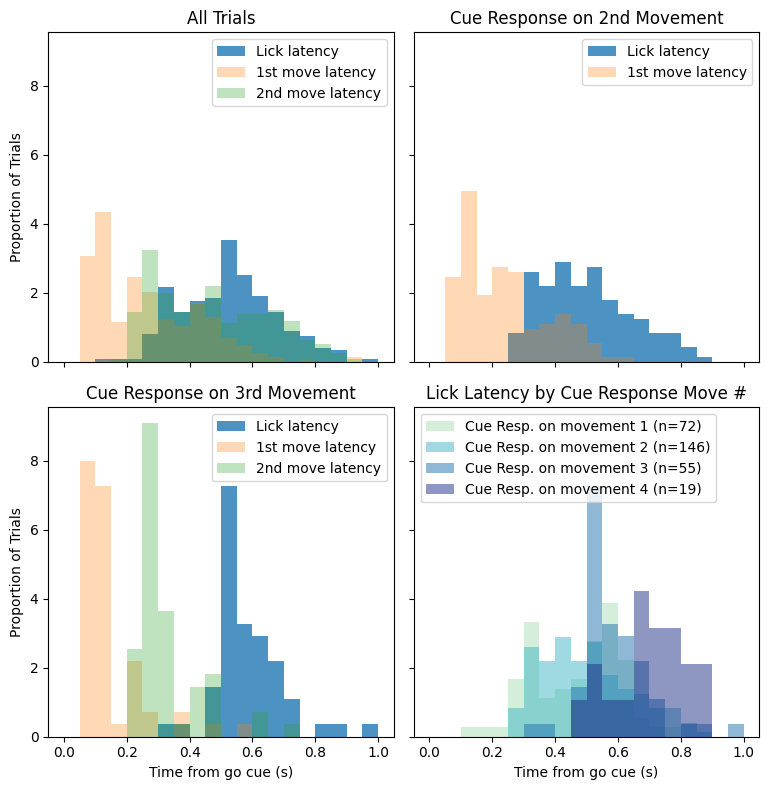

In [75]:
# plotting results: latency of cue response tongue movements, sorted by movement ordinal

# --- Shared settings ---
bins = np.arange(0, 1.05, 0.05)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.ravel()

# -------------------------------
# Subplot 1: All trials
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="All Trials", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 2: Cue response on 2nd movement
# -------------------------------
trials_2nd = df.loc[df['cue_response_movement_number'] == 2, 'trial'].unique()
df_2nd = df.query("trial in @trials_2nd and movement_number_in_trial <= 2")

lick_lat = df_2nd.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df_2nd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']

ax = axes[1]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.set(title="Cue Response on 2nd Movement")
ax.legend()

# -------------------------------
# Subplot 3: Cue response on 3rd movement
# -------------------------------
trials_3rd = df.loc[df['cue_response_movement_number'] == 3, 'trial'].unique()
df_3rd = df.query("trial in @trials_3rd and movement_number_in_trial <= 3")

lick_lat = df_3rd.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df_3rd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[2]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="Cue Response on 3rd Movement", xlabel="Time from go cue (s)", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 4: Lick latency by cue_response_movement_number (1-4)
# -------------------------------
per_trial = (
    tongue_movements
      .dropna(subset=['lick_latency', 'cue_response_movement_number'])
      .drop_duplicates('trial')                # <- critical: keep a single row per trial
      .copy()
)
lick_latencies_by_cue = (
    per_trial
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

cmap = plt.colormaps['YlGnBu']
colors = cmap(np.linspace(0.3, 0.9, 4))

ax = axes[3]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True, alpha=0.5,
        label=f"Cue Resp. on movement {n} (n={len(latencies)})",
        color=colors[n-1]
    )
ax.set(title="Lick Latency by Cue Response Move #", xlabel="Time from go cue (s)")
ax.legend(loc="upper left")

# --- Final layout ---
fig.tight_layout()
plt.show()

if SAVE_FIG:
    fname = FIG_DIR / "latency_cue-response_by_movement-ordinal"
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{fname}.svg", bbox_inches="tight")




